# Preparing data with the SeDF

The Spatially Enabled DataFrame, or SeDF, is a unique feature of the ArcGIS API for Python, and it's a fantastic tool for working with spatial data- it retains the ease of processing data that a Pandas DataFrame provides, while also making the data easily compatible with everything in the ArcGIS sphere. We're going to take a quick look at what the SeDF is before running through a demo showing the different aspects of it in action.

## The SeDF

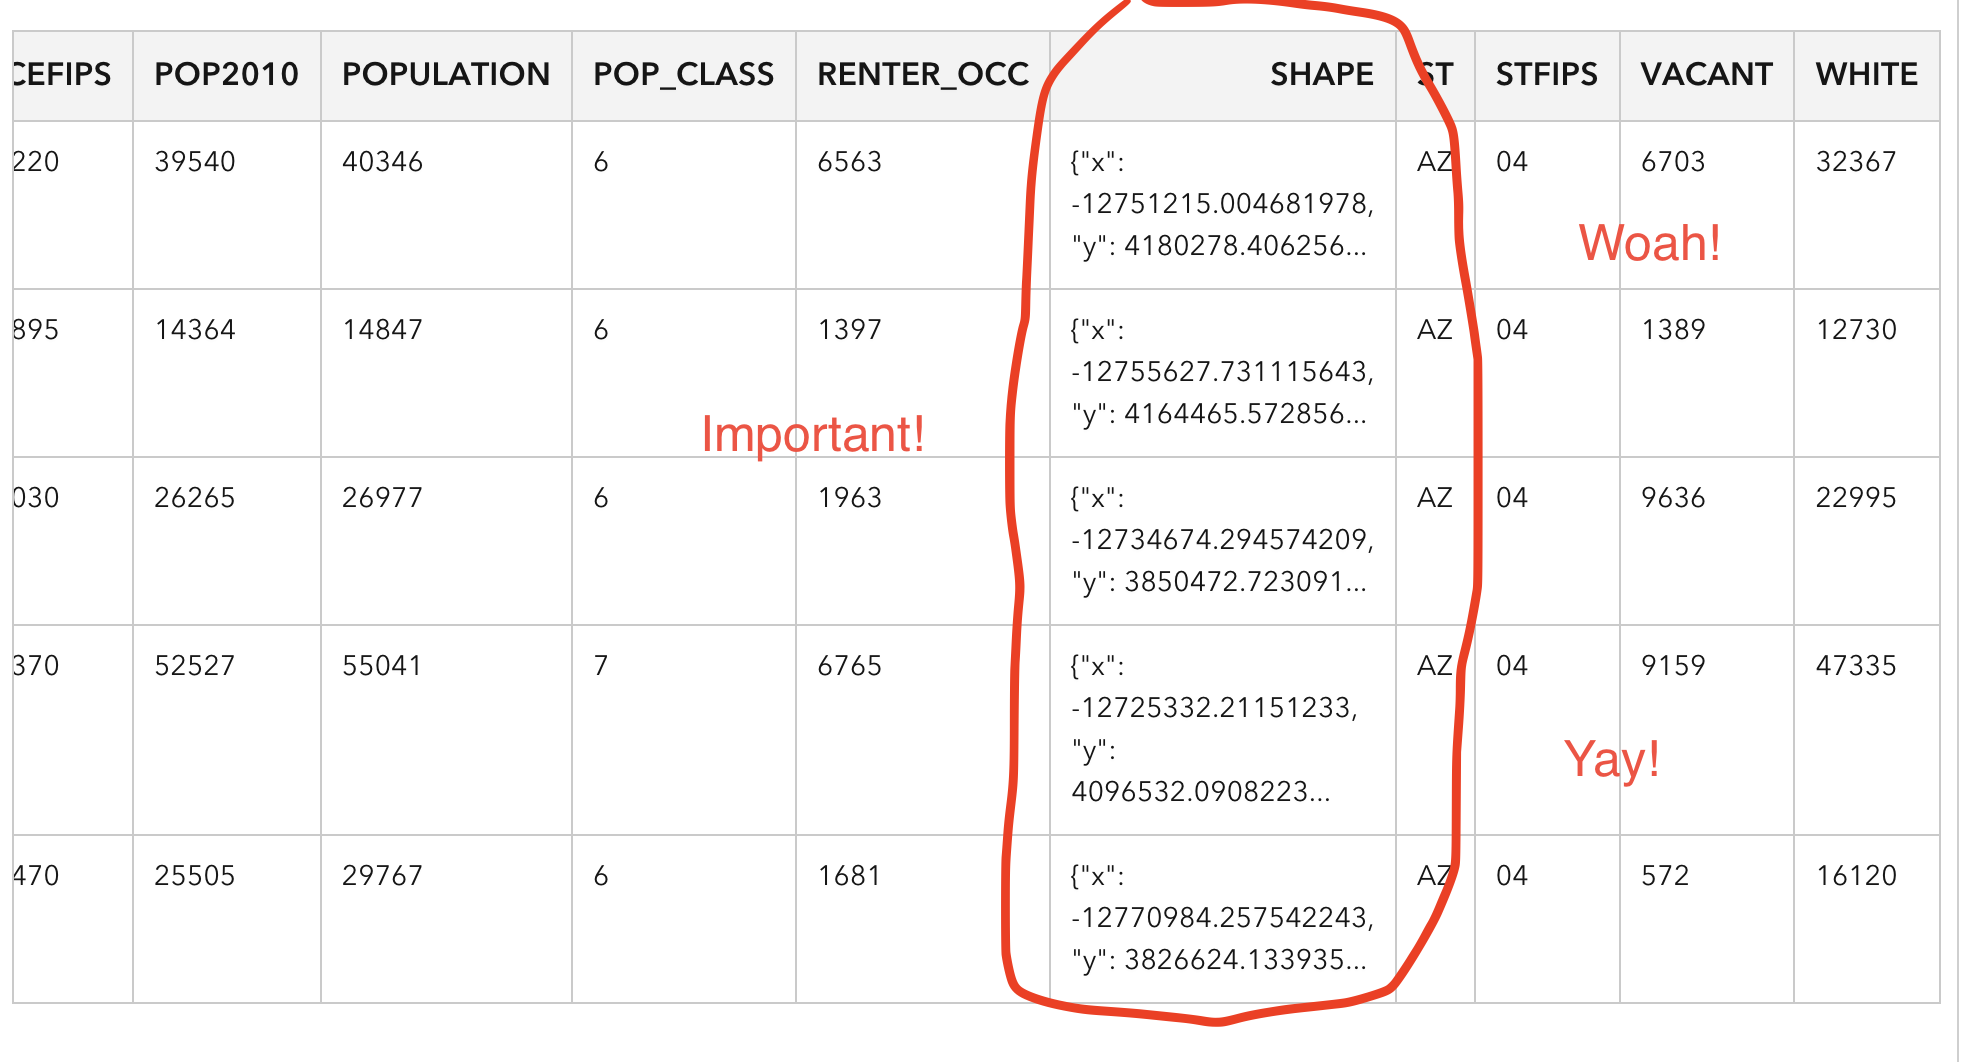

To understand the Spatially Enabled DataFrame, it's important to first take a look at a Pandas DataFrame. Pandas is one of the most commonly used libraries in Python, and DataFrames are a very helpful tool in the reportoire of any data scientist or analyst. They're two-dimensional, size-mutable tabular data structures that are easily traversable through Python code. You can think of them as data tables or Excel spreadsheets that allow you to run SQL-esque operations on them. Each row represents the data a single feature, and each column represents an attribute of that feature.

The main difference between a normal DataFrame and one of the ArcGIS API for Python's Spatially Enabled DataFrames is the addition of the `SHAPE` column. The `SHAPE` column adds geometry to each feature, providing compatibility with all sorts of functions in the ArcGIS sphere and allowing for easy execution of spatial operations. The SeDF is compatible with `ArcPy`, `pyshp`, `shapely`, and `fiona`, meaning that you should be able to use it with whatever sort of geometry engine you have in your environment. 

For those of you following along or reading this notebook after-the-fact, you can learn more about them here: https://developers.arcgis.com/python/guide/introduction-to-the-spatially-enabled-dataframe/

Now, let's get into it. We'll cover the specific syntax of the SeDF when get to it, as it works a little differently than most modules in the Python API.

### Import libaries, set up data paths, and read in the file

In [2]:
import pandas as pd
from pathlib import Path
from IPython.display import display
import requests

from arcgis.features import GeoAccessor, GeoSeriesAccessor
from arcgis.gis import GIS
gis = GIS(profile="your_online_profile")

In [3]:
airport_file = "/Users/cowboy/Downloads/airport-codes.csv"

### Inspect airport code data

The Pandas `read_csv()` function is an important one that you'll want to remember- it's an extremely easy way to get your CSV data into an easily manipulatable form, and it's the first step in getting a SeDF from a CSV file.

In [4]:
airport_df = pd.read_csv(airport_file)

In [5]:
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,coordinates
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,"40.07080078125, -74.93360137939453"
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,"38.704022, -101.473911"
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,"59.94919968, -151.695999146"
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,"34.86479949951172, -86.77030181884766"
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,"35.6087, -91.254898"


Now, here's our issue- how do we get this data into something we can perform spatial operations on? That coordinates column is essentially just meaningless string values to our geometry engines currently. If we wanted to do something like make a feature layer out of it, how would we get there? For starters, we should think about separating the latitude/longitude of each coordinates pair into their own columns. Let's examine some of the properties here.

### Get information about the DataFrame

In [6]:
type(airport_df)

pandas.core.frame.DataFrame

In [7]:
airport_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55113 entries, 0 to 55112
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         55113 non-null  object 
 1   type          55113 non-null  object 
 2   name          55113 non-null  object 
 3   elevation_ft  48180 non-null  float64
 4   continent     27368 non-null  object 
 5   iso_country   54866 non-null  object 
 6   iso_region    55113 non-null  object 
 7   municipality  49473 non-null  object 
 8   gps_code      41025 non-null  object 
 9   iata_code     9177 non-null   object 
 10  local_code    28790 non-null  object 
 11  coordinates   55113 non-null  object 
dtypes: float64(1), object(11)
memory usage: 5.0+ MB


In [8]:
airport_df.columns

Index(['ident', 'type', 'name', 'elevation_ft', 'continent', 'iso_country',
       'iso_region', 'municipality', 'gps_code', 'iata_code', 'local_code',
       'coordinates'],
      dtype='object')

### Transform the coordinates string to the necessary latitude and longitude decimal degree columns

In [9]:
airport_df.coordinates

0             40.07080078125, -74.93360137939453
1                         38.704022, -101.473911
2                    59.94919968, -151.695999146
3          34.86479949951172, -86.77030181884766
4                            35.6087, -91.254898
                          ...                   
55108                        40.542524, 122.3586
55109     41.784400939941406, 123.49600219726562
55110                          51.894444, 1.4825
55111    -11.584277777799999, 47.296388888900005
55112                      30.784722, 130.270556
Name: coordinates, Length: 55113, dtype: object

Pandas series are much like arrays in Python, but they have some added capabilities, such as label-based indexing. Columns in a DataFrame are Pandas series. We can isolate a single column from the rest of the DataFrame by calling it as an attribute of our DataFrame object.

In [10]:
type(airport_df.coordinates)

pandas.core.series.Series

Just like a Python array, we can index by number as well. Let's grab the element at a random index and examine what type of object it is.

In [11]:
airport_df.coordinates[29]

'43.94940185546875, -86.41670227050781'

In [12]:
type(airport_df.coordinates[29])

str

We'll bring all of these coordinate pairs into something we might be a little more familiar with, a Python list of strings. Pandas lets us do that easily with `to_list()`.

In [13]:
airport_df.coordinates.to_list()

['40.07080078125, -74.93360137939453',
 '38.704022, -101.473911',
 '59.94919968, -151.695999146',
 '34.86479949951172, -86.77030181884766',
 '35.6087, -91.254898',
 '34.9428028, -97.8180194',
 '34.305599212646484, -112.16500091552734',
 '35.350498199499995, -116.888000488',
 '39.427188, -121.763427',
 '32.7273736, -116.4597417',
 '40.622202, -104.344002',
 '28.64550018310547, -82.21900177001953',
 '28.846599578857422, -82.34539794921875',
 '27.230899810791016, -80.96920013427734',
 '33.76750183105469, -84.06829833984375',
 '33.88420104980469, -84.73390197753906',
 '19.832715, -155.980233',
 '48.145301818847656, -116.21399688720703',
 '39.724028, -101.395994',
 '41.644500732421875, -87.122802734375',
 '41.97840118408203, -89.5604019165039',
 '41.51139831542969, -87.2605972290039',
 '40.02560043334961, -89.1229019165039',
 '38.72779846191406, -94.93049621582031',
 '37.409400939941406, -84.61969757080078',
 '30.191944, -90.980833',
 '39.66529846191406, -89.70559692382812',
 '30.1362991333

Now, let's devise a way to split each of these pairs up. We'll try something out here on a small subset of the data using Python's `split` method.

In [14]:
for c in airport_df.coordinates.to_list()[:5]:
    print(f"{c.split(',')[0]:20}{' '*10}{c.split(',')[1]}")

40.07080078125                 -74.93360137939453
38.704022                      -101.473911
59.94919968                    -151.695999146
34.86479949951172              -86.77030181884766
35.6087                        -91.254898


That seemed to work well. Let's go ahead and do that on all of our data, except instead of printing them, we'll make new lists containing all of the lat or long values.

### Split coordinates column into new columns of float values for latitude & longitude

Rinse and repeat! Then, we can easily add them to our DataFrame by using the same syntax to how we would set a dictionary entry. We can also get rid of the coordinates column.

In [15]:
lat_vals = [float(coords.split(",")[0]) for coords in airport_df.coordinates.to_list()]
long_vals = [float(coords.split(",")[1]) for coords in airport_df.coordinates.to_list()]

In [16]:
airport_df["longitude"] = long_vals
airport_df["latitude"] = lat_vals

In [17]:
airport_df.drop(columns="coordinates", inplace=True)

Note the name of the function used to remove a column from the df- `drop()`. Let's look at our updated DataFrame.

In [18]:
airport_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,longitude,latitude
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,-74.933601,40.070801
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,-101.473911,38.704022
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,-151.695999,59.949200
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,-86.770302,34.864799
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,-91.254898,35.608700


Now, we're one step closer to being able to use our data for spatial functions. Let's overwrite our existing CSV so we can save our progress.

### Write out data to a new file

In [19]:
airport_df.to_csv(path_or_buf="/Users/cowboy/Downloads/airport-codes2.csv",
                  index=False,
                  index_label=False)

### Read into a DataFrame

In [20]:
airport_ed = pd.read_csv("/Users/cowboy/Downloads/airport-codes2.csv")
airport_ed.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,longitude,latitude
0,00A,heliport,Total Rf Heliport,11.0,NaN,US,US-PA,Bensalem,00A,NaN,00A,-74.933601,40.070801
1,00AA,small_airport,Aero B Ranch Airport,3435.0,NaN,US,US-KS,Leoti,00AA,NaN,00AA,-101.473911,38.704022
2,00AK,small_airport,Lowell Field,450.0,NaN,US,US-AK,Anchor Point,00AK,NaN,00AK,-151.695999,59.949200
3,00AL,small_airport,Epps Airpark,820.0,NaN,US,US-AL,Harvest,00AL,NaN,00AL,-86.770302,34.864799
4,00AR,closed,Newport Hospital & Clinic Heliport,237.0,NaN,US,US-AR,Newport,NaN,NaN,NaN,-91.254898,35.608700


Now, we'll take a look at our re-made DataFrame.

In [21]:
airport_ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55113 entries, 0 to 55112
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ident         55113 non-null  object 
 1   type          55113 non-null  object 
 2   name          55113 non-null  object 
 3   elevation_ft  48180 non-null  float64
 4   continent     27368 non-null  object 
 5   iso_country   54866 non-null  object 
 6   iso_region    55113 non-null  object 
 7   municipality  49473 non-null  object 
 8   gps_code      41025 non-null  object 
 9   iata_code     9177 non-null   object 
 10  local_code    28790 non-null  object 
 11  longitude     55113 non-null  float64
 12  latitude      55113 non-null  float64
dtypes: float64(3), object(10)
memory usage: 5.5+ MB


Now, we can take advantage of some of the other handy libraries that the arcgis build includes. We'll use Matplotlib's plotting functions to get a visual representation of how many of each type of airport there are.

In [22]:
airport_ed.type.value_counts()

small_airport     33998
heliport          11316
medium_airport     4531
closed             3618
seaplane_base      1014
large_airport       613
balloonport          23
Name: type, dtype: int64

<Axes: >

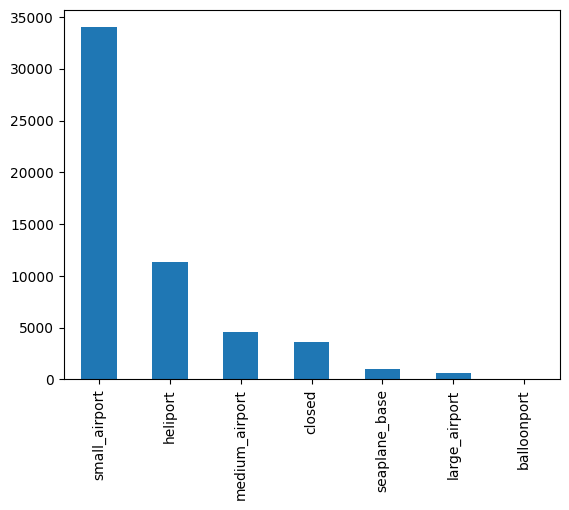

In [23]:
airport_ed.type.value_counts().plot(kind="bar")

## The `GeoAccessor` class and `.spatial` namespace

Now that we've looked at how normal Pandas DataFrames can be useful for processing data, we're getting into the best part: creating our Spatially Enabled DataFrame. 

All of the functions associated with a SeDF can be found in the Python API's `GeoAccessor` class; however, you'll rarely be calling that class by name. The Python API essentially adds in this class as a namespace onto a normal Pandas DataFrame, meaning you can access all of its functions by adding `.spatial` to a DataFrame. We'll give you a visual representation of this below, before chopping down our DataFrame to a subset that we'll spatially enable.

Read more here: https://developers.arcgis.com/python/api-reference/arcgis.features.toc.html#geoaccessor

In [31]:
pd.DataFrame.spatial?

In [24]:
type(airport_ed)

pandas.core.frame.DataFrame

In [ ]:
# note how if we hit tab, it'll suggest the spatial namespace for us
# and if we add a question mark after, it brings us to a reference
airport_ed

In [25]:
type(airport_ed.spatial)

arcgis.features.geo._accessor.GeoAccessor

In [26]:
# this is massive
airport_ed.shape

(55113, 13)

In [27]:
# let's only grab ones where the iata_code isn't null, for example
iata_df = airport_ed[airport_ed.iata_code.notnull()]
iata_df.head()

,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,longitude,latitude
223,03N,small_airport,Utirik Airport,4.0,OC,MH,MH-UTI,Utirik Island,K03N,UTK,03N,169.852005,11.222000
440,07FA,small_airport,Ocean Reef Club Airport,8.0,NaN,US,US-FL,Key Largo,07FA,OCA,07FA,-80.274803,25.325399
594,0AK,small_airport,Pilot Station Airport,305.0,NaN,US,US-AK,Pilot Station,NaN,PQS,0AK,-162.899994,61.934601
673,0CO2,small_airport,Crested Butte Airpark,8980.0,NaN,US,US-CO,Crested Butte,0CO2,CSE,0CO2,-106.928341,38.851918
1088,0TE7,small_airport,LBJ Ranch Airport,1515.0,NaN,US,US-TX,Johnson City,0TE7,JCY,0TE7,-98.622498,30.251801


In [28]:
iata_df.shape

(9177, 13)

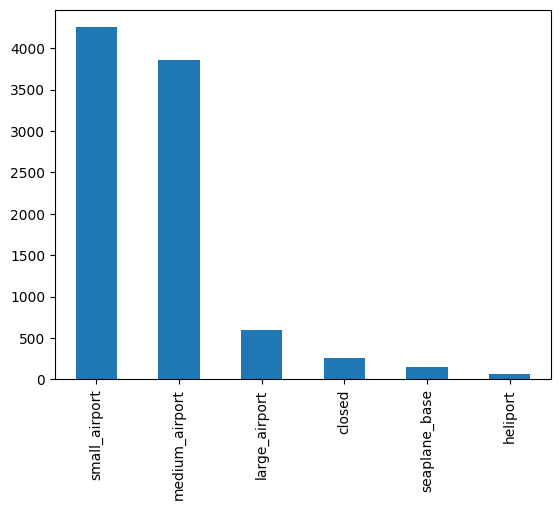

In [29]:
iata_df.type.value_counts().plot(kind="bar");

Now we'll reset the index and create our SeDF.

In [30]:
iata_df.reset_index(inplace=True)

### Create the spatially enabled dataframe from the CSV

We can use the `from_xy()` method to turn our normal DataFrame into a Spatially Enabled one- all we have to do is define what our X and Y columns are. We're going to try something crazy and use longitude and latitude.

In [32]:
iata_sedf = pd.DataFrame.spatial.from_xy(df=iata_df,
                                         x_column="longitude",
                                         y_column="latitude",
                                         sr=4326)

In [33]:
iata_sedf.head()

,index,ident,type,name,elevation_ft,continent,iso_country,iso_region,municipality,gps_code,iata_code,local_code,longitude,latitude,SHAPE
0,223,03N,small_airport,Utirik Airport,4.0,OC,MH,MH-UTI,Utirik Island,K03N,UTK,03N,169.852005,11.222000,"{""spatialReference"": {""wkid"": 4326}, ""x"": 169...."
1,440,07FA,small_airport,Ocean Reef Club Airport,8.0,NaN,US,US-FL,Key Largo,07FA,OCA,07FA,-80.274803,25.325399,"{""spatialReference"": {""wkid"": 4326}, ""x"": -80...."
2,594,0AK,small_airport,Pilot Station Airport,305.0,NaN,US,US-AK,Pilot Station,NaN,PQS,0AK,-162.899994,61.934601,"{""spatialReference"": {""wkid"": 4326}, ""x"": -162..."
3,673,0CO2,small_airport,Crested Butte Airpark,8980.0,NaN,US,US-CO,Crested Butte,0CO2,CSE,0CO2,-106.928341,38.851918,"{""spatialReference"": {""wkid"": 4326}, ""x"": -106..."
4,1088,0TE7,small_airport,LBJ Ranch Airport,1515.0,NaN,US,US-TX,Johnson City,0TE7,JCY,0TE7,-98.622498,30.251801,"{""spatialReference"": {""wkid"": 4326}, ""x"": -98...."


Note how we now have a `SHAPE` column. This adds geometries to every feature, which makes this set of data compatible with all sorts of stuff- plotting, feature analysis, and writing directly to a spatial content types (like feature layers). We'll take a quick look at these things.

## Visualizing and editing the features

Now our stuff is in a format that's easily compatible with the ArcGIS world- it makes life so much easier. We're going to highlight the convenience this brings by doing a few things- instantly visualizing our data, saving it as a feature layer, and using a SeDF to edit the features in that feature layer.

We'll start out by making a map, like we saw in the last demo. However, this time, we'll use the SeDF's `plot` method, which allows us to instantly represent our data with a custom renderer. In 2.1.0, we added the ability to use a host of custom coloring options with this function; we're going to grab a custom palette from Colorbrewer, and show how we could use a unique renderer to distinguish the points by country in a map.

In [ ]:
gis = GIS(profile="your_online_profile")

In [34]:
m1 = gis.map("France")
m1

MapView(layout=Layout(height='400px', width='100%'))

In [35]:
m1.remove_layers()
iata_sedf.spatial.plot(
    map_widget= m1,
    colors = ['rgb(141,211,199)','rgb(255,255,179)','rgb(190,186,218)','rgb(251,128,114)','rgb(128,177,211)','rgb(253,180,98)','rgb(179,222,105)','rgb(252,205,229)','rgb(217,217,217)','rgb(188,128,189)','rgb(204,235,197)','rgb(255,237,111)'],
    renderer_type = "u",
    marker_size=6,
    line_width=0.5,
    col = 'iso_country',
)

True

Fantastic. Now that we've seen our data and are happy with it, we can export it to a feature layer and easily save it in our portal; we do this with the `spatial.to_featurelayer()` function.

In [36]:
w_airports = iata_sedf.spatial.to_featurelayer(title="Worldwide Airports")

In [37]:
w_airports

<Item title:"Worldwide Airports" type:Feature Layer Collection owner:nparavicini_geosaurus>

Finally, the last thing we'll show here is how you can use the SeDF to edit the features of an existing feature layer in your portal- something that seems to be a popular topic for our users. We'll simply make a SeDF using the `spatial.from_layer()` method, take advantage of Pandas to change it real quick, and then call the `to_featurelayer()` method to overwrite the existing feature layer.

In [38]:
import pandas as pd
new_sedf = pd.DataFrame.spatial.from_layer(w_airports.layers[0])
new_sedf

,FID,SHAPE,continent,elevation_,gps_code,iata_code,ident,index_,iso_countr,iso_region,latitude,local_code,longitude,municipali,name,type
0,1,"{""x"": -11166895.66395635, ""y"": 6448017.5043084...",,1550.0,,YYI,CA-0313,13259,CA,CA-MB,50.010056,,-100.313931,,Rivers Airport,closed
1,2,"{""x"": -6974764.217822621, ""y"": 8067794.5362858...",,269.0,,YSV,CA-0322,13268,CA,CA-NL,58.475119,,-62.655373,RCAF Station Saglek,Saglek Airport,closed
2,3,"{""x"": -9695865.054658402, ""y"": 6243018.1717699...",,950.0,CYTJ,YTJ,CA-0378,13324,CA,CA-ON,48.811979,,-87.099438,"Terrace Bay, ON",Terrace Bay Airport,closed
3,4,"{""x"": -9475225.625647385, ""y"": 7405500.9108831...",,32.0,,YWN,CA-0412,13358,CA,CA-ON,55.2242,,-85.1174,Winisk,Winisk Airport,closed
4,5,"{""x"": -13929587.841160582, ""y"": 6517489.208391...",,360.0,,YRR,CA-0446,13392,CA,CA-BC,50.409447,,-125.131617,Big Bay,Stuart Island Airstrip,small_airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9172,9173,"{""x"": 12101096.708885185, ""y"": 1735723.3237669...",AS,10.0,VVCA,VCL,VVCA,51509,VN,VN-29,15.4033,,108.706001,Dung Quat Bay,Chu Lai International Airport,small_airport
9173,9174,"{""x"": 11880572.485052058, ""y"": 2370357.0433343...",AS,6.0,VVCI,HPH,VVCI,51510,VN,VN-61,20.819401,,106.724998,Haiphong,Cat Bi International Airport,medium_airport
9174,9175,"{""x"": 11708336.689727971, ""y"": 1026050.3464885...",AS,6.0,VVCM,CAH,VVCM,51512,VN,VN-59,9.177667,,105.177778,Ca Mau City,Cà Mau Airport,medium_airport
9175,9176,"{""x"": 12158203.661988217, ""y"": 1345503.6049185...",AS,40.0,VVCR,CXR,VVCR,51513,VN,VN-34,11.9982,,109.219002,Nha Trang,Cam Ranh Airport,medium_airport


In [39]:
bad_df = new_sedf[(new_sedf['iso_countr'] != 'US')].index
new_sedf.drop(bad_df, inplace=True)
new_sedf

,FID,SHAPE,continent,elevation_,gps_code,iata_code,ident,index_,iso_countr,iso_region,latitude,local_code,longitude,municipali,name,type
73,74,"{""x"": -14821967.003001783, ""y"": 7455351.828271...",,<NA>,CGA,CGA,CGA,14501,US,US-AK,55.478802,CGA,-133.147995,Craig,Craig Seaplane Base,seaplane_base
77,78,"{""x"": -16098022.040640177, ""y"": 9737431.147659...",,956.0,CHP,CHP,CHP,14561,US,US-AK,65.485497,CHP,-144.610992,Circle Hot Springs,Circle Hot Springs Airport,small_airport
78,79,"{""x"": -14717549.877778701, ""y"": 7404095.801087...",,0.0,,CIV,CIV,14575,US,US-AK,55.217,,-132.21,Chomley,Chomley Seaplane Base,seaplane_base
86,87,"{""x"": -17603507.065116353, ""y"": 8827887.588600...",,178.0,CJX,CKD,CJX,14712,US,US-AK,61.867901,CJX,-158.134995,Crooked Creek,Crooked Creek Airport,small_airport
92,93,"{""x"": -13692063.596641984, ""y"": 6206889.987363...",,108.0,,CKR,CKR,14833,US,US-WA,48.5978,,-122.9979,Crane Island,Crane Island Airstrip,small_airport
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,8756,"{""x"": 19955039.153396998, ""y"": 6688392.2636717...",,215.0,,AHT,US-0133,49182,US,US-AK,51.377778,,179.259167,Amchitka Island,Amchitka Army Airfield,closed
8756,8757,"{""x"": -7906559.451408594, ""y"": 5213929.6652322...",,0.0,MA87,BNH,US-0370,49419,US,US-MA,42.352502,MA87,-71.025832,Boston,Cape Air Seaplanes on Boston Harbor Seaplane Base,seaplane_base
8757,8758,"{""x"": -10590847.10959506, ""y"": 5371140.6443101...",,1434.0,,RTL,US-0F3,50033,US,US-IA,43.387501,0F3,-95.139198,Spirit Lake,Spirit Lake Municipal Airport,small_airport
8758,8759,"{""x"": -8181537.539944751, ""y"": 4975448.3557112...",,115.0,,BPA,US-BPA,50170,US,US-NY,40.749401,,-73.496002,Bethpage,Grumman Bethpage Airport,closed


In [40]:
updated_item = new_sedf.spatial.to_featurelayer(
    overwrite=True,
    service= {
        'featureServiceId' : 'eedb269114b445be9bc9fa65c9e23606',
        'layer' : 0,
    }
)

<Item title:"Worldwide Airports" type:Feature Layer Collection owner:nparavicini_geosaurus>
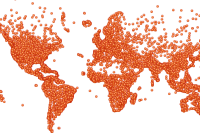

In [41]:
updated_item